In [119]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller


In [3]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})


In [2]:
file_path = "./datasets/GOOGL.csv"
df = pd.read_csv(file_path, parse_dates=[0])
df


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-27,1292.000000,1294.099976,1265.060059,1270.859985,1270.859985,2209300
1,2020-04-28,1283.199951,1284.760010,1230.380005,1232.589966,1232.589966,4035000
2,2020-04-29,1345.000000,1360.150024,1326.729980,1342.180054,1342.180054,5417900
3,2020-04-30,1331.359985,1350.000000,1321.500000,1346.699951,1346.699951,2792100
4,2020-05-01,1324.089966,1351.430054,1309.660034,1317.319946,1317.319946,2443600
...,...,...,...,...,...,...,...
248,2021-04-21,2272.050049,2280.000000,2244.820068,2278.350098,2278.350098,1160200
249,2021-04-22,2275.399902,2288.879883,2240.320068,2252.520020,2252.520020,1207300
250,2021-04-23,2267.000000,2306.120117,2261.250000,2299.929932,2299.929932,1453300
251,2021-04-26,2304.520020,2324.530029,2297.320068,2309.929932,2309.929932,1595200


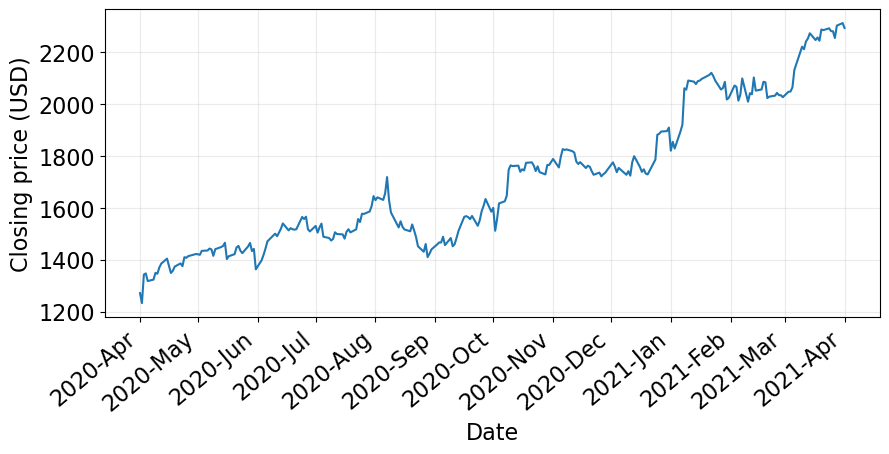

In [82]:
fig, ax = plt.subplots(figsize=(10, 4))

# x_year = pd.DatetimeIndex(df["Date"]).month
ax.plot(df["Date"], df["Close"])

formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(interval=1, bymonthday=27)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Closing price (USD)")

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

plt.show(fig)


## 3.1 The random walk process

A random walk model

$$
  y_{t} = C + y_{t-1} + \epsilon_t
$$

$y_t$ is the value at the present time $t$, $C$ is a constant,
$t_{t-1}$ is the value at the previous timestep $t-1$, 
and $\epsilon_t$ is a random number

### Generate random walk

In [94]:
seed = 20230822                       # set the random seed
rng = np.random.default_rng(seed)     # create Pseudo Random Nuber Generator
                                      # object
steps = rng.normal(size=1000)   # generate 1,000 random number
                                # from a normal distribution with
                                # a mean of 0 and a variance of 1.
steps[0] = 0            # Initialize the first value of the series to 0

# Calculate the cumulative sum of errors for each timestep
# in the simulated process
random_walk = np.cumsum(steps)
random_walk[:10]

array([ 0.        , -1.08399338, -1.11448859, -0.70430056, -0.04471421,
        1.67154292,  2.08900479,  2.06765211,  2.32811894,  4.05651038])

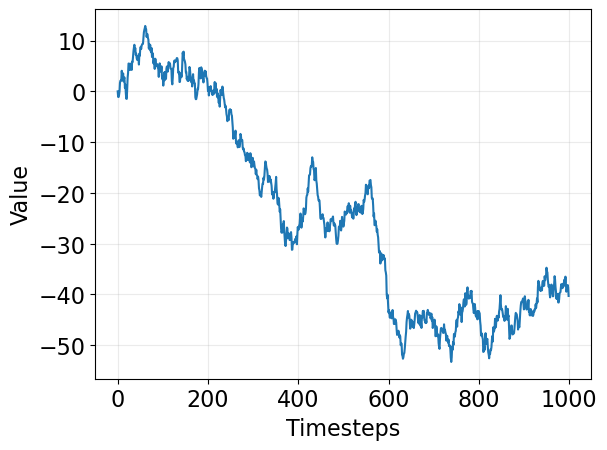

In [95]:
fig, ax = plt.subplots()

ax.plot(random_walk)
ax.set_xlabel("Timesteps")
ax.set_ylabel("Value")
ax.grid("on")

plt.show(fig)

## 3.2 Identifying a random walk

**Random walk**   
A random walk is a series whose first difference is stationary
and uncorrelated. This means that the process moves completely
at random.

**Stationarity**    
A stationary process is one whose statistical properties
do not change over time.    
A times series is said to be stationary if its mean, variance,
and autocorrelation do not change over time.

Some models that apply to stationary time series
- Moving average, $\text{MA}(q)$
- Autoregressive model, $\text{AR}(p)$
- Moving average + Autoregressive model, $\text{ARMA}(p,q)$

Non-stationary time series models
- Autoregressive integrated moving average, 
  $\text{ARIMA}(p, d, q)$
- Seasonal ARIMA, $\text{SARIMA}(p, d, q)(P, D, Q)_m$
- SARIMA with external variables, $\text{SARIMAX}$


Step-by-step to identify a random walk

<img src="./figures/identify-stationary.drawio.png" width=600>

**Transformation in time series forecasting**    
A transformation is a mathematical operation applied to a time
series in order to make it stationary.

Differencing is a transformation that calculates the change
from one timestep to another. This transformation is useful
for stabilizing the mean.

Applying a log function to the series can stabilize its variance.


**Augmented Dickey-Fuller (ADF) test**    
The augmented Dickey-Fuller (ADF) test helps us determine if 
a time series is stationary by testing for the presence of 
a unit root. If a unit root is present, the time series
is not stationary.

The null hypothesis states that t a unit root is present, 
meaning that our time series is not stationary.

General expression of times series $y_t$ that only depends
on its past values $y_{t-1}$ subject to a cofficient $\alpha_1$, 
a constant $C$, and whit noise $\epsilon_t$.

$$
  y_t = C + \alpha_1 y_{t-1} + \epsilon_t
$$

Here, $\alpha_1$ is also called the root of the time series.

In this general expression, the time series will be stationary
only if the root lies withing the unit circle. Therefore, its
value must be between $-1$ and $1$. Otherwise the series
is non-stationary.

Verifying the above statements.    
We generate two process:

$$
\begin{gather*}
  y_t = 0.5 y_{t-1} + \epsilon_t,   \\
  y_t = y_{t-1} + \epsilon_t
\end{gather*}
$$


In [99]:
def simulate_process(is_stationary: bool, seed: int=20230822) -> np.array:
  rng = np.random.default_rng(seed)
  N_timestep = 400
  process = np.empty(N_timestep)

  if is_stationary:
    alpha = 0.5
  else:
    alpha = 1.

  process[0]
  for i in range(N_timestep-1):
    process[i+1] = alpha*process[i] + rng.normal()

  return process

In [104]:
seed = 20230822 
stationary = simulate_process(True, seed)
non_stationary = simulate_process(False, seed)

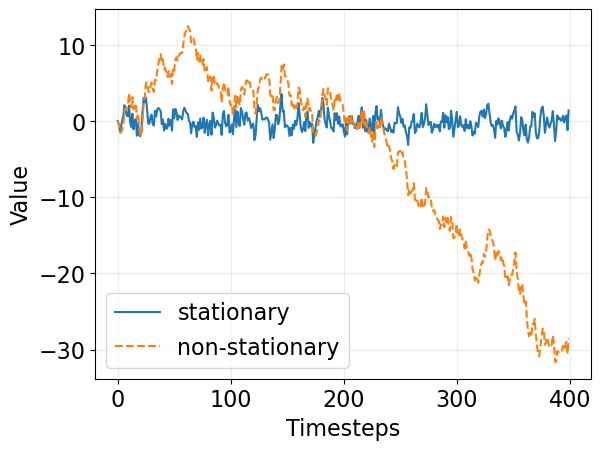

In [105]:
fig, ax = plt.subplots()

ax.plot(stationary, linestyle="-", label="stationary")
ax.plot(non_stationary, linestyle="--", label="non-stationary")

ax.set_xlabel("Timesteps")
ax.set_ylabel("Value")
ax.legend(loc="best")
ax.grid("on")

plt.show(fig)

Compute mean for those two processes

In [113]:
def mean_over_time(process: np.array) -> np.array:
  mean_func = []
  for i in range(len(process)):
    mean_func.append(np.mean(process[:i+1]))

  return np.array(mean_func)

In [114]:
stationary_mean = mean_over_time(stationary)
non_stationary_mean = mean_over_time(non_stationary)

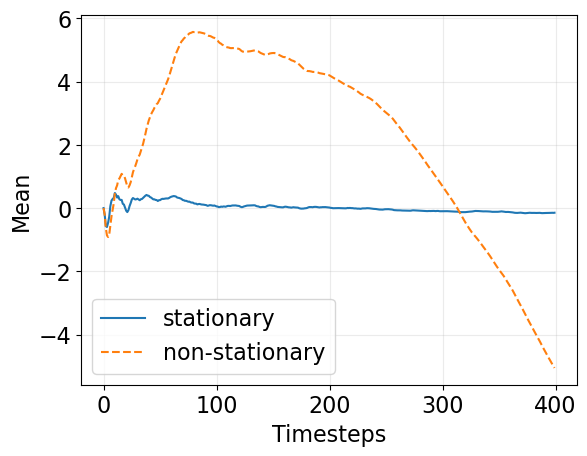

In [115]:
fig, ax = plt.subplots()

ax.plot(stationary_mean, linestyle="-", label="stationary")
ax.plot(non_stationary_mean, linestyle="--", label="non-stationary")

ax.set_xlabel("Timesteps")
ax.set_ylabel("Mean")
ax.legend(loc="best")
ax.grid("on")

plt.show(fig)


Compute variance for those two processes

In [116]:
def var_over_time(process: np.array) -> np.array:
  var_func = []
  for i in range(len(process)):
    var_func.append(np.var(process[:i+1]))

  return np.array(var_func)

In [117]:
stationary_var = var_over_time(stationary)
non_stationary_var = var_over_time(non_stationary)

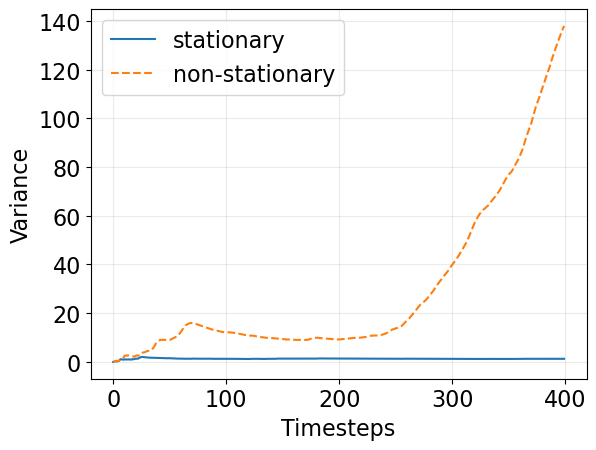

In [118]:
fig, ax = plt.subplots()

ax.plot(stationary_var, linestyle="-", label="stationary")
ax.plot(non_stationary_var, linestyle="--", label="non-stationary")

ax.set_xlabel("Timesteps")
ax.set_ylabel("Variance")
ax.legend(loc="best")
ax.grid("on")

plt.show(fig)

Experimenting with xticklabels of `mdates` with interval in month.
I would like to create a xticklabels such that for each month
there is a year label but only one occurrence during 12 months.

In [42]:
x_year = pd.DatetimeIndex(df["Date"]).year
x_month = pd.DatetimeIndex(df["Date"]).month
x_year_month = [(y, m) for y, m in zip(x_year, x_month)]
x_year_month = list(dict.fromkeys(x_year_month))
x_year_month = [""]

def fix_year_month_label(fig, ax):
  # We need to draw the canvas, otherwise the labels won't
  # be positioned and won't have values yet.
  fig.canvas.draw()

  labels = [item.get_text() for item in ax.get_xticklabels()]
  labels_fix = labels.copy()
  year_flag = labels[0].split("-")[0]
  for j, item in enumerate(labels[1:]):
    current_year_flag = item.split("-")[0]
    if current_year_flag == year_flag:
      # print(j, len(labels_fix), item)
      labels_fix[j+1] = item.split("-")[1]
    else:
      year_flag = current_year_flag

  return labels_fix
